In [1]:
import os
#获取目标文件夹下文件名称和文件数量-->获取所有图像的局部位置
#返回的lists_num中格式为{'filename':matrix...}
def getAll_name(filepath):
    filenum = 0
    pathDir = os.listdir(filepath)
    #for filename in pathDir:
        #child = os.path.join('%s%s' %(filepath,filename))
    lists = []
    lists_num = {}
    for line in pathDir:
        path = os.path.join(filepath,line)
        if os.path.isdir(path):
            print('it still has a folder')
        elif os.path:
            lists.append(line)
            pic = im.imread(path)
            #pic.shape
            filenum += 1
            tensor = pic[100:400,40:220,:]
            lists_num[line] = tensor
    lists_num['number'] = filenum
    return lists_num

In [2]:
#将图像按照stride距离分成块，便于下一步分类操作，保存形式为
def split_image(image,stride): 
    splits = {}
    height,width,channel = image.shape[0:3]  #0,1,2
    #width = images.shape[1]   
    #print(height , width, channel)
    #print(np.ceil(height/stride))
    number = 0
    rows = int(np.ceil(height/stride))
    cols = int(np.ceil(width/stride))
    for j in range(rows):
        for i in range(cols):
            temp = image[stride*j:stride*(j+1),stride*(i):stride*(i+1),:]
            number += 1
            splits[(j+1,i+1)] = temp
    splits['number'] = number
    splits['rows_and_cols'] = (rows,cols)
    #print('Split Completed')
    return splits

from decimal import *
def label_for_image(image_patch, threshold):
    rows,cols,channel = image_patch.shape
    #print(image_patch.shape)
    getcontext().prec = 10
    
    average = Decimal(int(sum(sum(image_patch[:,:,1]))))/Decimal((rows*cols))
    #print(sum(sum(image_patch[:,:,1])))
    #print (average)
    #显示图像进行测试
    #plt.imshow(image_patch)
    #plt.show()
    if average >= threshold:
        return 1
    else:
        return 0

In [3]:
#将每一副已分割图像切片，为切片贴标签
##lists代表诸如'215.jpg','216.jpg'之类文件的文件名和矩阵的字典{'215.jpg':matrix,...}
def split_each_output_image_and_label(lists,strides):
    images = {}
    images_splits = []
    images_labels = []
    for (k,v) in lists.items():
        #(k,v)为lists字典中的一个元组
        #v代表第m图像,k代表该图像名称
        ##字典的读取是无序的
        if k == 'number':
            continue
        #print('图像： ',k)
        patches = split_image(v,strides)
        patche_num = patches['number']
        rows, cols = patches['rows_and_cols']
        image = {}
        #对每一张图像的分片打标签
        for a in range(1,rows+1):
            for b in range(1,cols+1):
                label = label_for_image(patches[(a,b)],1)
                image[(a,b)] = label                       
                #把patch放入列表中，形式为[matrix1,matrix2,..]
                images_splits.append(patches[(a,b)])
                #"把patch对应的label放入列表中，形式为[1,0,0,....]"
                images_labels.append(label)
        images[k] = image       
    return [images, images_splits, images_labels]

#将每一副未分割图像切片，为切片贴标签
##lists代表诸如'215.jpg','216.jpg'之类文件的文件名和矩阵的字典{'215.jpg':matrix,...}
def split_each_input_image_and_label(lists,output_images,strides,validation_file):
    images = {}
    images_splits = []
    images_labels = []
    validation_splits = []
    validation_labels = []
    for (k,v) in lists.items():
        #(k,v)为lists字典中的一个元组
        #v代表第m图像,k代表该图像名称
        ##字典的读取是无序的
        if k == 'number':
            continue
        #print('图像： ',k)
        patches = split_image(v,strides)
        patche_num = patches['number']
        rows, cols = patches['rows_and_cols']
        image = {}
        #由于标签图像和对应的训练图像名称和扩展名不同，需要将文件名作更改
        output_k = k.replace('.jpg','1.bmp')
        #对每一张图像的分片打标签
        for a in range(1,rows+1):
            for b in range(1,cols+1):
                label = output_images[output_k][(a,b)]
                image[(a,b)] = label
                if k != validation_file:
                    #把patch放入列表中，形式为[matrix1,matrix2,..]
                    images_splits.append(patches[(a,b)])
                    #"把patch对应的label放入列表中，形式为[1,0,0,....]"
                    images_labels.append(label)
                else:
                    #print('验证/测试图像：',k)
                    #把patch放入列表中，形式为[matrix1,matrix2,..]
                    validation_splits.append(patches[(a,b)])
                    #"把patch对应的label放入列表中，形式为[1,0,0,....]"
                    validation_labels.append(label)                
        images[k] = image       
    return [images, images_splits, images_labels, validation_splits, validation_labels]    

In [4]:
#将标签转化为one_hot_encode编码形式
def one_hot_encode(x):
    #x为0/1二值数
    images_label_for_one_hot_encode = []
    images_label_for_one_hot_encode = np.eye(2)[x]
    # TODO: Implement Function
    return images_label_for_one_hot_encode

In [5]:
import numpy as np
def one_hot_encode_to_one(x):
    select_num = np.argmax(x,1)
    return select_num

#Test
print(one_hot_encode_to_one([[0,1],[1,0]]))

[1 0]


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
def neural_net_image_input(shape):
    #返回一个tensor表示一个batch的输入图像
    x = tf.placeholder(tf.float32, [None,shape[0],shape[1],shape[2]],name='x')
    return x

def neural_net_label_input(n_classes):
    y = tf.placeholder(tf.float32, [None,n_classes],name='y')
    return y
    
def neural_net_keep_prob_input():
    keep_prob = tf.placeholder(tf.float32,name='keep_prob')
    return keep_prob

def variable_with_weight_loss(shape, mean, stddev, wl, name):
    var = tf.Variable(tf.truncated_normal(shape,mean=mean,stddev=stddev))
    if wl is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var),wl,name=name)
        tf.add_to_collection('losses',weight_loss)
    return var

def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    #weights = tf.Variable(tf.truncated_normal([conv_ksize[0],conv_ksize[1],x_tensor.get_shape().as_list()[-1],conv_num_outputs],mean=0.0,stddev=0.1),name='weights_conv')
    weights = variable_with_weight_loss([conv_ksize[0],conv_ksize[1],x_tensor.get_shape().as_list()[-1],conv_num_outputs],mean=0.0,stddev=0.1,wl=0.0,name='weights_conv')
    biases = tf.Variable(tf.zeros(conv_num_outputs),name='biases_conv')
    conv = tf.nn.conv2d(x_tensor,weights,strides=[1,conv_strides[0],conv_strides[1],1],padding='SAME')
    conv = tf.nn.bias_add(conv,biases)
    conv = tf.nn.relu(conv)
    return conv

def pool2d(conv,pool_ksize,pool_strides):
    conv_maxpool = tf.nn.max_pool(conv,ksize=[1,pool_ksize[0],pool_ksize[1],1],strides=[1,pool_strides[0],pool_strides[1],1],padding='SAME')
    return conv_maxpool

def flatten(x_tensor):
    shape = x_tensor.get_shape().as_list()
    flat = tf.placeholder(tf.float32, [None,shape[1]*shape[2]*shape[3]])
    flat = tf.reshape(x_tensor,[-1,shape[1]*shape[2]*shape[3]])
    return flat

def fully_layer(x_tensor, num_outputs):
    #weights = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[-1],num_outputs],mean=0.0,stddev=0.1),name='weights_fully')
    weights = variable_with_weight_loss([x_tensor.get_shape().as_list()[-1],num_outputs],mean=0.0,stddev=0.04,wl=0.004,name='weights_fully')
    biases = tf.Variable(tf.constant(0.1,shape=[num_outputs]),name='biases_fully')
    fully_conv = tf.add(tf.matmul(x_tensor,weights),biases)
    fully_conv = tf.nn.relu(fully_conv)
    return fully_conv

def output_layer(x_tensor, num_outputs):
    #weights = tf.Variable(tf.truncated_normal([x_tensor.get_shape().as_list()[-1],num_outputs],mean=0.0,stddev=0.1),name='weights_output')
    weights = variable_with_weight_loss([x_tensor.get_shape().as_list()[-1],num_outputs],mean=0.0,stddev=1/64.0,wl=0.0,name='weights_output')
    biases = tf.Variable(tf.zeros(num_outputs),name='biases_output')
    output = tf.add(tf.matmul(x_tensor,weights),biases)
    return output


In [7]:
def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 30, 30, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 2],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')

In [10]:
p = tf.constant('123')
with tf.Session() as sess:
    print(sess.run(p))

AttributeError: module 'tensorflow' has no attribute 'constant'

In [9]:
def conv_net(x, keep_prob):
    conv1 = conv2d(x,32,(5,5),(1,1))
    max_pool1 = pool2d(conv1,(2,2),(1,1))
    #后执行LRN
    norm1 = tf.nn.lrn(max_pool1,4,bias=1.0,alpha=0.001/9.0,beta=0.75)
    conv2 = conv2d(norm1,64,(3,3),(1,1))
    #先执行LRN
    norm2 = tf.nn.lrn(conv2,4,bias=1.0,alpha=0.001/9.0,beta=0.75)
    max_pool2 = pool2d(norm2,(2,2),(1,1))
    conv3 = conv2d(max_pool2,128,(2,2),(1,1))
    fconv1 = flatten(conv3)
    fconv1 = fully_layer(fconv1,64)
    fconv1 = tf.nn.dropout(fconv1,keep_prob)
    out = output_layer(fconv1,2)
    return out

#搭建网络
#删去之前保存的权值、bias值等
tf.reset_default_graph()
#确定输入数据规格
x = neural_net_image_input((30,30,3))
y = neural_net_label_input(2)
keep_prob = neural_net_keep_prob_input()

#搭建模型
logits = conv_net(x, keep_prob)
print(logits.get_shape())

#Name logits Tensor, so that it can be loaded ffrom disk after training
logits = tf.identity(logits, name='logits')

#损失函数和优化函数
def loss(logits, y):
    y = tf.cast(y,tf.int64)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y),name='cross_entropy')
    tf.add_to_collection('losses',cost)
    return tf.add_n(tf.get_collection('losses'),name='total_loss')

cost = loss(logits,y)
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cost)

#计算正确值
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

test_conv_net(conv_net)

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

In [9]:
#测试训练网络是否搭建成功
from unittest.mock import MagicMock
def test_train_nn(train_neural_network):
    mock_session = tf.Session()
    test_x = np.random.rand(60, 30, 30, 3)
    test_y = np.random.rand(60, 2)
    test_k = np.random.rand(1)
    test_optimizer = tf.train.AdamOptimizer()

    mock_session.run = MagicMock()
    train_neural_network(mock_session, test_optimizer, test_k, test_x, test_y)

    assert mock_session.run.called, 'Session not used'

    print('Tests Passed')

In [10]:
#执行训练网络
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer,feed_dict={x:feature_batch,y:label_batch,keep_prob:keep_probability})
test_train_nn(train_neural_network)

Tests Passed


In [11]:
#对每一部分（一段迭代次数）的训练计算loss和validation_accuracy
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = session.run(cost,feed_dict={x:feature_batch, y:label_batch, keep_prob:1.})
    validation_accuracy = session.run(accuracy,feed_dict={x:validation_splits,y:validation_labels,keep_prob:1.})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,validation_accuracy))

In [12]:
#按batch_size量取出train_data(使用yield生成器)
def get_train_data_by_batch(features, labels, batch_size):
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield [features[start:end], labels[start:end]]

In [13]:
#设置网络基本参数
epochs = 20
batch_size = 60
keep_probability = 0.5

In [14]:
#载入各项数据
#获取输入数据和标签数据的矩阵
lists_inputs_dict = getAll_name("liver")
lists_outputs_dict = getAll_name("mask")
#对获取的输入输出矩阵做分块、加标签和列表预处理
[images_outputs, images_outputs_splits, images_outputs_labels] = split_each_output_image_and_label(lists_outputs_dict,30)
[images_inputs, images_inputs_splits, images_inputs_labels, validation_splits, validation_labels] = split_each_input_image_and_label(lists_inputs_dict,images_outputs,30,"241.jpg")
images_inputs_labels = one_hot_encode(images_inputs_labels)
validation_labels = one_hot_encode(validation_labels)
print('训练数据长度：',len(images_inputs_splits))
print('标签数据长度：',len(images_outputs_splits))

训练数据长度： 2040
标签数据长度： 2100


In [118]:
print('Training:')
save_model_path = './LiverCut'
for_test_label = []
with tf.Session() as sess:
    #初始化variables
    sess.run(tf.global_variables_initializer())
    #Training cycle
    for epoch in range(epochs):
        for train_features, train_labels in get_train_data_by_batch(images_inputs_splits,images_inputs_labels, batch_size):
            train_neural_network(sess,optimizer,keep_probability,train_features,train_labels)
        print('epoch {:>2}, LiverForTrain:  '.format(epoch+1),end='')
        print_stats(sess,train_features,train_labels,cost,accuracy)
    #保存测试数据
    for_test_label = sess.run(logits,feed_dict={x:validation_splits,keep_prob:1.0})
    for_test_label = tf.identity(for_test_label,name='for_test_label')
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training:
epoch  1, LiverForTrain:  Loss:    17.4119 Validation Accuracy: 0.766667
epoch  2, LiverForTrain:  Loss:    16.0708 Validation Accuracy: 0.800000
epoch  3, LiverForTrain:  Loss:    14.9762 Validation Accuracy: 0.833333
epoch  4, LiverForTrain:  Loss:    13.8903 Validation Accuracy: 0.833333
epoch  5, LiverForTrain:  Loss:    12.9239 Validation Accuracy: 0.850000
epoch  6, LiverForTrain:  Loss:    12.0525 Validation Accuracy: 0.916667
epoch  7, LiverForTrain:  Loss:    11.3989 Validation Accuracy: 0.900000
epoch  8, LiverForTrain:  Loss:    10.6768 Validation Accuracy: 0.900000
epoch  9, LiverForTrain:  Loss:    10.0669 Validation Accuracy: 0.916667
epoch 10, LiverForTrain:  Loss:     9.5792 Validation Accuracy: 0.950000
epoch 11, LiverForTrain:  Loss:     9.0401 Validation Accuracy: 0.933333
epoch 12, LiverForTrain:  Loss:     8.6479 Validation Accuracy: 0.933333
epoch 13, LiverForTrain:  Loss:     8.2615 Validation Accuracy: 0.933333
epoch 14, LiverForTrain:  Loss:     7.874

In [15]:
#Test Model
save_model_path = './LiverCut'
def test_model():
    #载入各项数据
    #获取输入数据和标签数据的矩阵
    lists_inputs_dict = getAll_name("liver")
    lists_outputs_dict = getAll_name("mask")
    #对获取的输入输出矩阵做分块、加标签和列表预处理
    [images_outputs, images_outputs_splits, images_outputs_labels] = split_each_output_image_and_label(lists_outputs_dict,30)
    [images_inputs, images_inputs_splits, images_inputs_labels, validation_splits, validation_labels] = split_each_input_image_and_label(lists_inputs_dict,images_outputs,30,"241.jpg")
    images_inputs_labels = one_hot_encode(images_inputs_labels)
    validation_labels = one_hot_encode(validation_labels)
    loaded_graph = tf.Graph()
    
    with tf.Session(graph=loaded_graph) as sess:
        #加载模型 
        loader = tf.train.import_meta_graph(save_model_path+'.meta')
        loader.restore(sess, save_model_path)
        
        #获得加载模型的Tensor
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        loaded_valid = loaded_graph.get_tensor_by_name('for_test_label:0')
        loaded_valid = sess.run(loaded_valid)
        #获得根据batch_size得到的正确率（Get accuracy in batches for memory limitations）
        test_batch_acc_total = 0
        #test_batch_count = 0
        
        test_splits = validation_splits
        test_labels = validation_labels
        
        test_batch_acc_total = sess.run(loaded_acc,feed_dict={loaded_x: test_splits, loaded_y: test_labels, loaded_keep_prob: 1.0})
        print('The Model Testing Accuracy: {}\n'.format(test_batch_acc_total))
        return [loaded_valid,validation_splits,validation_labels]
        
[loaded_valid, valid_splits, valid_labels] = test_model()

The Model Testing Accuracy: 0.949999988079071



In [16]:
#将logits的结果利用softmax分类器处理后得出最终的分类
def softmax(logits):
    num,m = logits.shape
    soft = []    
    for i in range(num):
        soft_for_i = []
        sums = np.exp(logits[i][0])+np.exp(logits[i][1])
        for j in range(m):
            soft_for_i.append(np.exp(logits[i][j])/sums)
        select_num = np.argmax(soft_for_i)
        for h in range(m):
            if h == select_num:
                soft_for_i[h] = 1
            else:
                soft_for_i[h] = 0
        soft.append(soft_for_i)
    return soft

#num,m = loaded_valid.shape
#logit为网络输出结果
logit_list = softmax(loaded_valid)
logit_matrix = np.array(np.reshape(one_hot_encode_to_one(logit_list),[10,6]))
y_list = softmax(valid_labels)
y_matrix = np.array(np.reshape(one_hot_encode_to_one(y_list),[10,6]))
correct_pred = np.equal(np.argmax(logit_list,1),np.argmax(y_list,1))
correct_matrix = np.reshape(correct_pred,[10,6])
true_num = len([i for i in correct_pred if i == True])
getcontext().prec = 15
correct_rate = Decimal(true_num)/Decimal(len(correct_pred))
print(logit_matrix)
print(y_matrix)
print(correct_matrix)
print('{:>8.4f}'.format(correct_rate))



[[0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 1 0 0]
 [0 1 1 0 0 0]
 [0 1 1 1 0 0]
 [0 1 1 1 0 1]
 [0 1 1 1 0 0]
 [0 1 1 0 0 0]
 [0 1 1 0 0 0]
 [0 0 0 0 0 0]]
[[0 0 0 0 0 0]
 [0 0 0 1 0 0]
 [0 0 1 1 1 0]
 [0 1 1 0 0 0]
 [0 1 1 1 0 0]
 [0 1 1 1 0 0]
 [0 1 1 1 0 0]
 [0 1 1 1 0 0]
 [0 1 1 0 0 0]
 [0 0 0 0 0 0]]
[[ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True False  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True False]
 [ True  True  True  True  True  True]
 [ True  True  True False  True  True]
 [ True  True  True  True  True  True]
 [ True  True  True  True  True  True]]
  0.9500


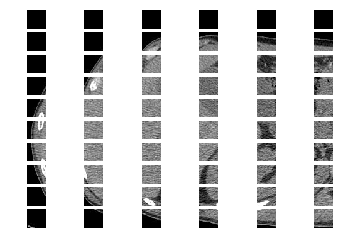

In [17]:
#显示验证切片
fig, ax = plt.subplots(nrows = 10, ncols = 6)
a = 1
now = 0
for row in ax:
    b=1
    for col in row:
        col.imshow(valid_splits[now])
        col.axis('off')
        now+=1
        b+=1
    a+=1
#plt.imshow(splits[(3,2)])
plt.show()

In [18]:
print(one_hot_encode_to_one(validation_labels))

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0
 1 1 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0]


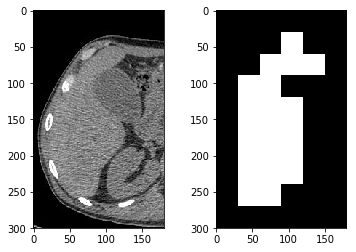

In [19]:
#将分片的图像合并为一张图像（只限于splits正好为一张图像的情况）
def split_to_one(splits,labels,strides):
    
    height = int(np.ceil(300/strides))
    width = int(np.ceil(180/strides))
    #print('height:',height,'width',width)
    image_valid = np.zeros([300,180,3])
    image_binary = np.zeros([300,180,3])
    labels_valid = one_hot_encode_to_one(labels)
    #splits_reshape = np.zeros([len(splits),])
    #for i in range(len(splits)):
       # splits_reshape = np.reshape(np.array(splits[:],),[height,width])
    #labels_reshape = np.reshape(np.array(labels_valid),[height,width])
    start_y = 0
    for i in range(height):
        end_y = min(start_y+strides,300)
        start_x = 0
        for j in range(width):
            end_x = min(start_x+strides,180)
            image_valid[start_y:end_y,start_x:end_x,:] = splits[i*width+j][:,:,:]
            if labels_valid[i*width+j] == 0:
                splits[i*width+j][:,:] = 0
            elif labels_valid[i*width+j] == 1:
                splits[i*width+j][:,:] = 1
            image_binary[start_y:end_y,start_x:end_x,:] = splits[i*width+j][:,:,:]
            start_x = end_x
        start_y = end_y
    return [image_valid,image_binary]

import copy
imshow_copy = copy.deepcopy(valid_splits)
imshow_labels = copy.deepcopy(valid_labels)
image = split_to_one(imshow_copy,imshow_labels,30)
fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(image[0].astype(np.uint8))
ax = fig.add_subplot(122)
ax.imshow(image[1])

plt.savefig('Test_image.png')
plt.show()



            

In [158]:
print(image[0].shape)

(300, 180, 3)


In [159]:
print(valid_splits[10].shape)

(30, 30, 3)


In [167]:
def gray2d(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

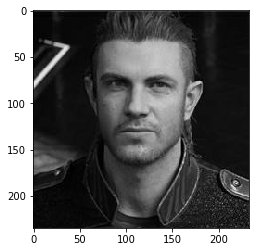

In [176]:
pic = im.imread('./nex.png')
ima = gray2d(pic)
plt.imshow(ima, cmap = plt.get_cmap('gray'))
plt.show()

In [169]:
pic.shape

(512, 512)